# PDI - Rebalancing data for June 2022

## Setting

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
from defillama import DefiLlama
llama = DefiLlama()

In [4]:
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Token inclusion criteria

1. **Project and token characteristics** 
    1. The project must have a listing on Defi Llama
    1. The project’s token should have been listed on CoinGecko with pricing data at least 1 year prior to the date of inclusion in the index. 
    1. The project should have a token that is native to Ethereum L1 or L2. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project. 
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible. 
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.

1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange.
    1. The token should have at least $5mm of onchain liquidity on a single pair.
    1. The token must have shown consistent DeFi liquidity on Ethereum.

1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available. Alternatively, the protocol must have been operating long enough to create a consensus about its safety in the decentralised finance community.

### Tokens list

#### DefiLlama

In [6]:
protocols = llama.get_all_protocols()

In [7]:
top_defi_tokens = {} 
for pr in protocols[:1000]:
    if 'Ethereum' in pr['chains'] and pr['address'] and pr['address']!='-' and pr['symbol'] != '-':
        symbol = ''.join(c for c in pr['symbol'] if c.isalnum()).upper()
        top_defi_tokens[symbol] = {
            'symbol': symbol, 
            'address': pr['address'].lower()
        }

In [8]:
top_defi_tokens['XSUSHI'] = {
    'symbol': 'XSUSHI',
    'address': "0x8798249c2e607446efb7ad49ec89dd1865ff4272",
}

#### CoinGecko

##### Tokens addresses

In [9]:
coins_list = pd.DataFrame(cg.get_coins_list(include_platform=True))

In [10]:
tokens = {} 
tokens_by_addr = {}
for index, coin in coins_list.iterrows():
    if len(coin['platforms']) >= 1 and 'ethereum' in list(coin['platforms'].keys()):
        symbol = ''.join(c for c in coin['symbol'] if c.isalnum()).upper()
        address = coin['platforms']['ethereum'].lower()
        token = {
            'symbol': symbol,
            'address': address 
        }
        tokens[symbol] = token
        tokens_by_addr[address] = token

In [11]:
tokens['USDC'], tokens['WETH']

({'symbol': 'USDC', 'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'})

In [12]:
# These token's addresses cant be found in the coingecko list of eth addresses
exclude_symbols = []
for symb, token in top_defi_tokens.items():
    if token['address'] not in tokens_by_addr.keys():
        print(token)
        exclude_symbols.append(token['symbol'])

{'symbol': 'MULTI', 'address': '0x9fb9a33956351cf4fa040f65a13b835a3c8764e3'}
{'symbol': 'IB', 'address': 'fantom:0x00a35fd824c717879bf370e70ac6868b95870dfb'}
{'symbol': 'COW', 'address': 'heco:0x80861a817106665bca173db6ac2ab628a738c737'}
{'symbol': 'ABR', 'address': 'celo:0x6e512bfc33be36f2666754e996ff103ad1680cc9'}
{'symbol': 'FLAG', 'address': '0x57dd84042ec9507963016596a34edad42f7e4cce '}
{'symbol': 'LYRA', 'address': 'optimism:0x50c5725949a6f0c72e6c4a641f24049a917db0cb'}
{'symbol': 'SGT', 'address': '0x84810bcf08744d5862b8181f12d17bfd57d3b078'}
{'symbol': 'RSR', 'address': '0x8762db106b2c2a0bccb3a80d1ed41273552616e8'}
{'symbol': 'FHM', 'address': '0xfa1fbb8ef55a4855e5688c0ee13ac3f202486286'}
{'symbol': 'GRO', 'address': '0x09e64c2b61a5f1690ee6fbed9baf5d6990f8dfd0'}
{'symbol': 'SWPR', 'address': 'arbitrum:0xde903e2712288a1da82942dddf2c20529565ac30'}
{'symbol': 'SOLV', 'address': '0x256f2d67e52fe834726d2ddcd8413654f5eb8b53'}
{'symbol': 'HND', 'address': 'hundredfinance.jpg'}
{'symbol

In [13]:
for symb in exclude_symbols:
    del top_defi_tokens[symb]

In [14]:
# KEEP has this address in defillama, but etherscan says this address belongs to tBTC now
for token in top_defi_tokens.values():
    if token['address'] == "0x8daebade922df735c38c80c7ebd708af50815faa":
        print(token)
del top_defi_tokens['KEEP']

{'symbol': 'KEEP', 'address': '0x8daebade922df735c38c80c7ebd708af50815faa'}


##### Market data

In [15]:
cg_tokens_data = cg.get_coins_markets(vs_currency='USD', order='market_cap_desc')
for i in range(2, 20):
    cg_tokens_data.extend(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', page=i))
    
cg_tokens_data = pd.DataFrame.from_records(cg_tokens_data)

In [16]:
tokens_market_data = cg_tokens_data.set_index(cg_tokens_data['symbol'].str.upper())

In [17]:
tokens_market_data.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
BTC,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,29818.000,568969047140,1,6.274344e+11,2.490015e+10,30746.000,...,2.100000e+07,21000000.0,69045.00,-56.77191,2021-11-10T14:24:11.849Z,67.810000,43915.88641,2013-07-06T00:00:00.000Z,None,2022-05-18T12:14:13.376Z
ETH,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2029.850,245759845921,2,NaN,1.588536e+10,2118.270,...,NaN,NaN,4878.26,-58.34764,2021-11-10T14:24:19.604Z,0.432979,469186.36507,2015-10-20T00:00:00.000Z,"{'times': 89.94716676123599, 'currency': 'btc'...",2022-05-18T12:13:33.605Z
USDT,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.000,74246811053,3,NaN,4.744890e+10,1.006,...,7.420900e+10,NaN,1.32,-24.37503,2018-07-24T00:00:00.000Z,0.572521,74.76921,2015-03-02T00:00:00.000Z,None,2022-05-18T12:12:23.165Z
USDC,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,1.002,52279964270,4,NaN,5.339665e+09,1.008,...,5.215861e+10,NaN,1.17,-14.55940,2019-05-08T00:40:28.300Z,0.891848,12.34730,2021-05-19T13:14:05.611Z,None,2022-05-18T12:13:41.003Z
BNB,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,301.430,50792013377,5,5.079201e+10,1.484998e+09,310.360,...,1.681370e+08,168137035.9,686.31,-56.00477,2021-05-10T07:24:17.097Z,0.039818,758211.54209,2017-10-19T00:00:00.000Z,None,2022-05-18T12:13:40.699Z


### Liquidity check

In [18]:
dex_subgraph_urls = {
    'univ2': "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2",
    'sushi': "https://api.thegraph.com/subgraphs/name/zippoxer/sushiswap-subgraph-fork",
} 

In [19]:
base_tokens = [tokens['USDC'], tokens['WETH']]
base_tokens

[{'symbol': 'USDC', 'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'}]

In [20]:
query = """
    query pairs ($token0_ids: [ID!]!, $token1_ids: [ID!]!) {
        pairs (first:1000, where: {token0_in: $token0_ids, token1_in: $token1_ids}){
            id
            token0 {
              id
            }
            token1 {
              id
            }
            reserveUSD
        }
    }
    """

In [21]:
base_tokens_ids = [token['address'] for token in base_tokens]
tokens_ids = [token['address'] for symb, token in top_defi_tokens.items()]

In [22]:
rows = {token['symbol']: {} for token in top_defi_tokens.values()}
for dex_name, url in dex_subgraph_urls.items():
    request = requests.post(url, json={'query': query, 'variables': {'token0_ids': base_tokens_ids, 'token1_ids': tokens_ids}})
    pairs1 = request.json()['data']['pairs']

    request = requests.post(url, json={'query': query, 'variables': {'token0_ids': tokens_ids, 'token1_ids': base_tokens_ids}})
    pairs2 = request.json()['data']['pairs']
    
    pairs = pairs1 + pairs2
    
    print(f"{dex_name}: {len(pairs)} pairs")
    
    for pair in pairs:
        if pair['token0']['id'] in base_tokens_ids:
            base_token = tokens_by_addr[pair['token0']['id']]
            token = tokens_by_addr[pair['token1']['id']]
        else:
            base_token = tokens_by_addr[pair['token1']['id']]
            token = tokens_by_addr[pair['token0']['id']]
        
        colname = f"{dex_name}_{base_token['symbol']}" 
        
        rows[token['symbol']][colname] = float(pair['reserveUSD'])

univ2: 274 pairs
sushi: 150 pairs


In [23]:
liquidities = pd.DataFrame.from_dict(rows, orient='index')
liq_check = (liquidities > 5e6).any(axis=1).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [24]:
lq_passed = tokens_market_data[
    tokens_market_data.index.isin(liq_check_passed.index)
]

In [25]:
lq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
WBTC,wrapped-bitcoin,wbtc,Wrapped Bitcoin,https://assets.coingecko.com/coins/images/7598...,29784.000000,8456944413,13,8.456944e+09,3.212852e+08,30709.000000,...,2.832540e+05,2.832540e+05,70643.000000,-57.75324,2021-11-10T14:40:19.650Z,3139.170000,850.71360,2019-04-02T00:00:00.000Z,None,2022-05-18T12:14:25.004Z
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.210000,2385733220,34,5.226260e+09,1.404452e+08,5.530000,...,1.000000e+09,1.000000e+09,44.920000,-88.40468,2021-05-03T05:25:04.822Z,1.030000,405.58518,2020-09-17T01:20:38.214Z,None,2022-05-18T12:14:25.216Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,89.580000,1234428305,57,1.437533e+09,2.130938e+08,95.900000,...,1.600000e+07,1.600000e+07,661.690000,-86.42749,2021-05-18T21:19:59.514Z,26.020000,245.10799,2020-11-05T09:20:11.928Z,None,2022-05-18T12:13:13.310Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,1.470000,531930166,106,1.474393e+09,9.023331e+06,1.610000,...,1.000000e+09,1.000000e+09,7.300000,-79.69952,2021-08-20T08:35:20.158Z,0.505506,193.27424,2021-03-27T09:10:29.155Z,None,2022-05-18T12:13:50.750Z
FXS,frax-share,fxs,Frax Share,https://assets.coingecko.com/coins/images/1342...,8.110000,489448569,111,8.080218e+08,1.694562e+07,8.630000,...,9.947588e+07,9.947588e+07,42.800000,-81.07494,2022-01-12T15:22:27.465Z,1.500000,438.85694,2021-06-25T16:50:51.447Z,None,2022-05-18T12:13:46.032Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,68.600000,471612072,115,6.878736e+08,5.735876e+07,75.140000,...,1.000000e+07,1.000000e+07,910.540000,-92.44112,2021-05-12T02:29:08.794Z,54.910000,25.33792,2022-05-12T07:18:59.691Z,None,2022-05-18T12:13:42.589Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,10045.290000,356686420,129,3.681830e+08,6.230781e+07,10319.970000,...,3.666600e+04,3.666600e+04,90787.000000,-88.96342,2021-05-12T00:29:37.713Z,31.650000,31562.90543,2020-07-18T12:26:27.150Z,None,2022-05-18T12:13:13.974Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.400000,270739311,162,3.510820e+08,1.180688e+08,1.480000,...,2.421803e+08,2.500000e+08,23.380000,-94.02272,2021-03-13T23:44:36.774Z,0.475381,193.92767,2020-11-04T14:53:53.560Z,None,2022-05-18T12:12:29.951Z
SYN,synapse-2,syn,Synapse,https://assets.coingecko.com/coins/images/1802...,1.430000,263226009,167,3.569121e+08,1.089072e+07,1.540000,...,NaN,2.500000e+08,4.920000,-70.97193,2021-10-24T00:24:41.805Z,0.389600,266.23473,2021-09-21T21:19:58.123Z,None,2022-05-18T12:13:53.213Z


### Non quantative checks

In [26]:
exclude_list = [
    {
        'symbol': 'WBTC',
        'reason': 'Criteria 1.C'
    },
    {
        'symbol': 'XSUSHI',
        'reason': 'Duplicates SUSHI'
    },
    {
        'symbol': 'ERN',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'NFTX',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'FXS',
        'reason': 'Criteria 1.G'
    },
    {
        'symbol': 'RGT',
        'reason': 'Deprecated asset'
    },
    {
        'symbol': 'SUPER',
        'reason': 'Not DeFi'
    }
]
exclude_symbols = [token['symbol'] for token in exclude_list]

In [27]:
nq_passed = lq_passed[
    ~lq_passed.index.isin(exclude_symbols)
]

In [28]:
nq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.210000,2385733220,34,5.226260e+09,1.404452e+08,5.530000,...,1.000000e+09,1.000000e+09,44.920000,-88.40468,2021-05-03T05:25:04.822Z,1.030000,405.58518,2020-09-17T01:20:38.214Z,None,2022-05-18T12:14:25.216Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,89.580000,1234428305,57,1.437533e+09,2.130938e+08,95.900000,...,1.600000e+07,1.600000e+07,661.690000,-86.42749,2021-05-18T21:19:59.514Z,26.020000,245.10799,2020-11-05T09:20:11.928Z,None,2022-05-18T12:13:13.310Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,1.470000,531930166,106,1.474393e+09,9.023331e+06,1.610000,...,1.000000e+09,1.000000e+09,7.300000,-79.69952,2021-08-20T08:35:20.158Z,0.505506,193.27424,2021-03-27T09:10:29.155Z,None,2022-05-18T12:13:50.750Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,68.600000,471612072,115,6.878736e+08,5.735876e+07,75.140000,...,1.000000e+07,1.000000e+07,910.540000,-92.44112,2021-05-12T02:29:08.794Z,54.910000,25.33792,2022-05-12T07:18:59.691Z,None,2022-05-18T12:13:42.589Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,10045.290000,356686420,129,3.681830e+08,6.230781e+07,10319.970000,...,3.666600e+04,3.666600e+04,90787.000000,-88.96342,2021-05-12T00:29:37.713Z,31.650000,31562.90543,2020-07-18T12:26:27.150Z,None,2022-05-18T12:13:13.974Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.400000,270739311,162,3.510820e+08,1.180688e+08,1.480000,...,2.421803e+08,2.500000e+08,23.380000,-94.02272,2021-03-13T23:44:36.774Z,0.475381,193.92767,2020-11-04T14:53:53.560Z,None,2022-05-18T12:12:29.951Z
SYN,synapse-2,syn,Synapse,https://assets.coingecko.com/coins/images/1802...,1.430000,263226009,167,3.569121e+08,1.089072e+07,1.540000,...,NaN,2.500000e+08,4.920000,-70.97193,2021-10-24T00:24:41.805Z,0.389600,266.23473,2021-09-21T21:19:58.123Z,None,2022-05-18T12:13:53.213Z
TOKE,tokemak,toke,Tokemak,https://assets.coingecko.com/coins/images/1749...,6.050000,88990150,309,6.053475e+08,4.098660e+05,6.350000,...,1.000000e+08,1.000000e+08,79.020000,-92.35023,2021-11-04T00:35:29.799Z,5.700000,6.06824,2022-05-12T18:50:54.340Z,None,2022-05-18T12:13:52.099Z
ALCX,alchemix,alcx,Alchemix,https://assets.coingecko.com/coins/images/1411...,33.260000,43292732,482,7.965083e+07,3.019868e+06,35.270000,...,1.994952e+06,2.393060e+06,2066.200000,-98.39117,2021-03-20T19:33:19.740Z,28.550000,16.42811,2022-05-12T22:34:00.644Z,None,2022-05-18T12:13:38.629Z


### Retrieve historical data & livetime check

In [29]:
exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for index, data in nq_passed[['id', 'symbol']].iterrows():
    id_ = data['id']
    symbol = data['symbol'].upper()
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', symbol])
    df_prices = df_prices[df_prices[symbol] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < 365:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < 365 days')
        exclude_list.append(symbol)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', symbol])
    df_mcaps = df_mcaps[df_mcaps[symbol] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < 365:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < 365 days')
        ## continue
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)
    
    

Excluding SYN, prices data available only for 262 < 365 days
Excluding TOKE, prices data available only for 285 < 365 days
Excluding FLX, prices data available only for 157 < 365 days
Excluding MIST, prices data available only for 161 < 365 days


In [30]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

In [31]:
lt_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.21,2385733220,34,5.226260e+09,140445233.0,5.53,...,1.000000e+09,1.000000e+09,44.92,-88.40468,2021-05-03T05:25:04.822Z,1.030000,405.58518,2020-09-17T01:20:38.214Z,None,2022-05-18T12:14:25.216Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,89.58,1234428305,57,1.437533e+09,213093790.0,95.90,...,1.600000e+07,1.600000e+07,661.69,-86.42749,2021-05-18T21:19:59.514Z,26.020000,245.10799,2020-11-05T09:20:11.928Z,None,2022-05-18T12:13:13.310Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,1.47,531930166,106,1.474393e+09,9023331.0,1.61,...,1.000000e+09,1.000000e+09,7.30,-79.69952,2021-08-20T08:35:20.158Z,0.505506,193.27424,2021-03-27T09:10:29.155Z,None,2022-05-18T12:13:50.750Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,68.60,471612072,115,6.878736e+08,57358764.0,75.14,...,1.000000e+07,1.000000e+07,910.54,-92.44112,2021-05-12T02:29:08.794Z,54.910000,25.33792,2022-05-12T07:18:59.691Z,None,2022-05-18T12:13:42.589Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,10045.29,356686420,129,3.681830e+08,62307811.0,10319.97,...,3.666600e+04,3.666600e+04,90787.00,-88.96342,2021-05-12T00:29:37.713Z,31.650000,31562.90543,2020-07-18T12:26:27.150Z,None,2022-05-18T12:13:13.974Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.40,270739311,162,3.510820e+08,118068751.0,1.48,...,2.421803e+08,2.500000e+08,23.38,-94.02272,2021-03-13T23:44:36.774Z,0.475381,193.92767,2020-11-04T14:53:53.560Z,None,2022-05-18T12:12:29.951Z
ALCX,alchemix,alcx,Alchemix,https://assets.coingecko.com/coins/images/1411...,33.26,43292732,482,7.965083e+07,3019868.0,35.27,...,1.994952e+06,2.393060e+06,2066.20,-98.39117,2021-03-20T19:33:19.740Z,28.550000,16.42811,2022-05-12T22:34:00.644Z,None,2022-05-18T12:13:38.629Z
BOND,barnbridge,bond,BarnBridge,https://assets.coingecko.com/coins/images/1281...,3.66,24583655,653,3.661593e+07,15497098.0,3.84,...,1.000000e+07,1.000000e+07,185.69,-98.02438,2020-10-27T00:36:32.813Z,3.060000,19.76304,2022-05-14T16:14:28.237Z,None,2022-05-18T12:13:46.046Z


### Marketcap ranking & top10 filtering

In [32]:
chosen_tokens = lt_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [33]:
chosen_tokens

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.21,2385733220,34,5.226260e+09,140445233.0,5.53,...,1.000000e+09,1.000000e+09,44.92,-88.40468,2021-05-03T05:25:04.822Z,1.030000,405.58518,2020-09-17T01:20:38.214Z,None,2022-05-18T12:14:25.216Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,89.58,1234428305,57,1.437533e+09,213093790.0,95.90,...,1.600000e+07,1.600000e+07,661.69,-86.42749,2021-05-18T21:19:59.514Z,26.020000,245.10799,2020-11-05T09:20:11.928Z,None,2022-05-18T12:13:13.310Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,1.47,531930166,106,1.474393e+09,9023331.0,1.61,...,1.000000e+09,1.000000e+09,7.30,-79.69952,2021-08-20T08:35:20.158Z,0.505506,193.27424,2021-03-27T09:10:29.155Z,None,2022-05-18T12:13:50.750Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,68.60,471612072,115,6.878736e+08,57358764.0,75.14,...,1.000000e+07,1.000000e+07,910.54,-92.44112,2021-05-12T02:29:08.794Z,54.910000,25.33792,2022-05-12T07:18:59.691Z,None,2022-05-18T12:13:42.589Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,10045.29,356686420,129,3.681830e+08,62307811.0,10319.97,...,3.666600e+04,3.666600e+04,90787.00,-88.96342,2021-05-12T00:29:37.713Z,31.650000,31562.90543,2020-07-18T12:26:27.150Z,None,2022-05-18T12:13:13.974Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.40,270739311,162,3.510820e+08,118068751.0,1.48,...,2.421803e+08,2.500000e+08,23.38,-94.02272,2021-03-13T23:44:36.774Z,0.475381,193.92767,2020-11-04T14:53:53.560Z,None,2022-05-18T12:12:29.951Z
ALCX,alchemix,alcx,Alchemix,https://assets.coingecko.com/coins/images/1411...,33.26,43292732,482,7.965083e+07,3019868.0,35.27,...,1.994952e+06,2.393060e+06,2066.20,-98.39117,2021-03-20T19:33:19.740Z,28.550000,16.42811,2022-05-12T22:34:00.644Z,None,2022-05-18T12:13:38.629Z
BOND,barnbridge,bond,BarnBridge,https://assets.coingecko.com/coins/images/1281...,3.66,24583655,653,3.661593e+07,15497098.0,3.84,...,1.000000e+07,1.000000e+07,185.69,-98.02438,2020-10-27T00:36:32.813Z,3.060000,19.76304,2022-05-14T16:14:28.237Z,None,2022-05-18T12:13:46.046Z


In [34]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [35]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

In [36]:
prices_data

,UNI,AAVE,LDO,COMP,YFI,SUSHI,ALCX,BOND
date,,,,,,,,
2021-03-02,25.592699,386.507922,0.849448,494.358379,34900.371111,18.798040,1050.297397,56.050115
2021-03-03,25.673868,392.581993,0.879645,501.438114,33400.696195,17.925825,991.795750,52.260027
2021-03-04,25.486634,397.858343,0.836782,494.206140,33881.025287,17.517664,1376.135328,57.280345
2021-03-05,28.368215,376.610205,0.687990,472.457882,32560.148658,17.408828,1139.907512,55.329831
2021-03-06,28.308459,369.647205,0.783612,479.153858,32137.453888,16.690631,1167.196998,58.316153
...,...,...,...,...,...,...,...,...
2022-05-14,5.081028,82.426547,1.475366,68.205798,9933.794381,1.418404,31.411051,3.360034
2022-05-15,5.196501,87.009565,1.487854,71.796965,10304.127321,1.320300,33.446478,3.336024
2022-05-16,5.448515,92.087935,1.474096,74.861539,10589.620697,1.391730,36.141104,3.632102


In [37]:
marketcaps

,UNI,AAVE,LDO,COMP,YFI,SUSHI,ALCX,BOND
date,,,,,,,,
2021-03-02,7.871645e+09,4.751222e+09,1.181185e+07,2.142571e+09,1.237769e+09,2.362758e+09,3.338203e+07,7.552599e+07
2021-03-03,7.938771e+09,4.878411e+09,1.224257e+07,2.175709e+09,1.188119e+09,2.273568e+09,3.126962e+07,7.110369e+07
2021-03-04,7.933740e+09,4.948727e+09,1.185368e+07,2.154215e+09,1.210977e+09,2.240011e+09,4.418676e+07,7.802084e+07
2021-03-05,8.803390e+09,4.684718e+09,9.733795e+06,2.054969e+09,1.156134e+09,2.211941e+09,3.647704e+07,7.517484e+07
2021-03-06,8.703822e+09,4.580840e+09,1.101787e+07,2.077348e+09,1.153659e+09,2.123790e+09,3.716741e+07,7.902313e+07
...,...,...,...,...,...,...,...,...
2022-05-14,2.310355e+09,1.137073e+09,5.181269e+08,4.667323e+08,3.513412e+08,2.419873e+08,4.056655e+07,2.257929e+07
2022-05-15,2.370053e+09,1.184520e+09,5.152140e+08,4.907949e+08,3.662544e+08,2.529114e+08,4.339160e+07,2.235631e+07
2022-05-16,2.483832e+09,1.262719e+09,5.247790e+08,5.113315e+08,3.739601e+08,2.674064e+08,4.683234e+07,2.433515e+07


## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 30%.
* All excess weight is proportionally redistributed to all uncapped tokens. After this has been completed, if another token now exceeds the 30% threshold the excess will be redistributed to the remaining uncapped tokens. This process will occur iteratively until there are no tokens that exceed the maximum weight.
* Any asset with a weight below 0.5% will be removed from the index.


### Weight mcaps

In [38]:
weights = marketcaps.div(marketcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

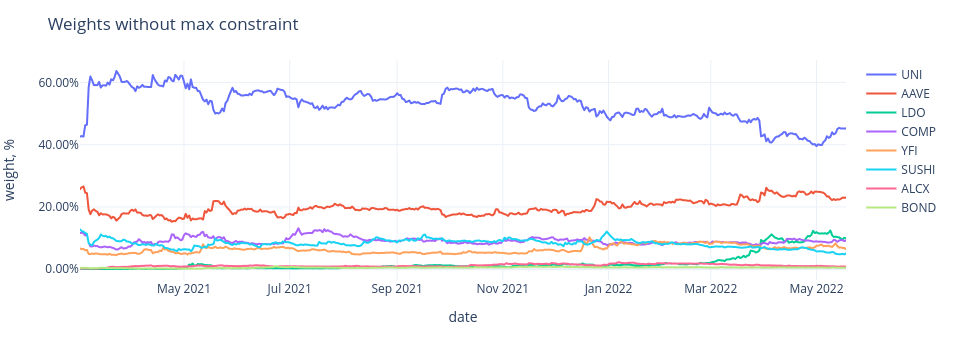

In [39]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

### Adjust weights

This process adjusts weights to adhere to the weight constraints described in our methodology. In addition the `remove_tiny_weights` function checks for any assets with a weight below the minimum threshold of $0.5\%$ and proportionally increases all remaining weights (which are $> 0.5\%$). Note that after this procedure readjusting weights to respect maximum may be needed.

In [40]:
def adjust_weights(weights, max_weight):
    w = weights.copy()
    
    while (w > max_weight).any(axis=None):
        w[w > max_weight] = max_weight
        c = 1 - w.sum(axis=1)
        w_less = w[w < max_weight]
        w[(w < max_weight) & (w > 0)] += w_less.div(w_less.sum(axis=1), axis=0).mul(c, axis=0)
    
    return w

In [41]:
def remove_tiny_weights(weights, min_weight):
    w = weights.copy()
    
    w[w < min_weight] = 0
    w = w.div(w.sum(axis=1), axis=0)
    
    return w

In [42]:
adjusted_weights = adjust_weights(weights, max_weight=0.3) 
adjusted_weights = remove_tiny_weights(adjusted_weights, min_weight=0.005)
adjusted_weights = adjust_weights(adjusted_weights, max_weight=0.3)

adjusted_weights = adjusted_weights.sort_values(adjusted_weights.last_valid_index(),ascending=False, axis = 1)
adjusted_weights

,UNI,AAVE,LDO,COMP,YFI,SUSHI,ALCX,BOND
date,,,,,,,,
2021-03-02,0.3,0.300000,0.000000,0.147291,0.085090,0.162427,0.000000,0.005192
2021-03-03,0.3,0.300000,0.000000,0.154377,0.084303,0.161320,0.000000,0.000000
2021-03-04,0.3,0.300000,0.000000,0.151619,0.085232,0.157658,0.000000,0.005491
2021-03-05,0.3,0.300000,0.000000,0.149501,0.084110,0.160921,0.000000,0.005469
2021-03-06,0.3,0.300000,0.000000,0.152920,0.084924,0.156339,0.000000,0.005817
...,...,...,...,...,...,...,...,...
2022-05-14,0.3,0.286478,0.130538,0.117590,0.088518,0.060967,0.010220,0.005689
2022-05-15,0.3,0.288361,0.125424,0.119479,0.089161,0.061569,0.010563,0.005442
2022-05-16,0.3,0.293523,0.121986,0.118860,0.086928,0.062159,0.010886,0.005657


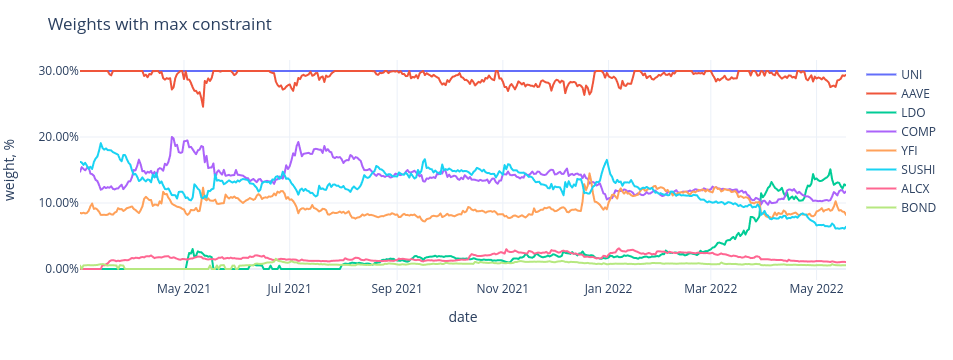

In [43]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

### Convert weights to the [1, 255] scale

On the contract side weights are integer numbers from the interval $[1, 255]$ with total sum $255$, so it's needed to convert retrieved weights to this format.

Note that one can't just round weights to integers after scaling, since it doesn't guarantee that their sum will be $255$. To fix that firstly floor function is applied to the weights and then $1$ is being added to the $k$ weights with largest fractional parts.

In [44]:
def convert_weights(weights):
    w_scaled = weights * 255
    w_res = np.floor(w_scaled).astype(int)
    
    remainders = w_scaled - w_res
    
    k = round(remainders.sum())
    k_largest_rems = np.argsort(remainders)[::-1][:k]
    
    w_res[k_largest_rems] += 1
    
    return w_res 

In [51]:
last_weights = adjusted_weights.iloc[-1].dropna()

In [52]:
converted_last_weights = convert_weights(last_weights)

## Summary table

In [50]:
pdi = pd.DataFrame()
pdi.index = chosen_tokens.index
pdi['name'] = chosen_tokens['name']
pdi['market_cap'] = marketcaps.iloc[-1].astype(int)
pdi['price'] = prices_data.iloc[-1]
pdi['weight'] = last_weights
pdi['weight_converted'] = converted_last_weights
pdi['address'] = [top_defi_tokens[symb]['address'] for symb in pdi.index]

pdi = pdi[pdi['weight'] > 0]
pdi

,name,market_cap,price,weight,weight_converted,address
symbol,,,,,,
UNI,Uniswap,2503550357,5.488523,0.300000,77,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984
AAVE,Aave,1273754903,92.898628,0.294053,75,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9
LDO,Lido DAO,548424210,1.525301,0.126607,32,0x5a98fcbea516cf06857215779fd812ca3bef1b32
COMP,Compound,508177782,74.197755,0.117316,30,0xc00e94cb662c3520282e6f5717214004a7f26888
YFI,yearn.finance,355287069,10002.993191,0.082020,21,0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e
SUSHI,Sushi,277313093,1.437278,0.064019,16,0x6b3595068778dd592e39a122f4f5a5cf09c90fe2
ALCX,Alchemix,44995298,34.499034,0.010387,3,0xdbdb4d16eda451d0503b854cf79d55697f90c8df
BOND,BarnBridge,24249316,3.610795,0.005598,1,0x0391d2021f89dc339f60fff84546ea23e337750f
